# Introduction to Artificial Neural Networks with Keras

* Implementing MLPs with Keras

# Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sys
import keras_tuner as kt

為了防止一些Sklearn更新的不必要警告:

In [2]:
# import warnings filter
from warnings import simplefilter
import warnings
#ugnore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [3]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Implementing MLPs with Keras

## Building an Image Classifier Using the Sequential API

首先，需要加載數據集。 Fashion MNIST，它是 MNIST的替代品。它具有與 MNIST 完全相同的格式（70,000 張灰圖像，每張 28×28 像素，有 10 個類別），但圖像代表時尚商品而不是手寫數字，因此每個類別更加多樣化，問題也更加明顯 比 MNIST 更具挑戰性。 例如，簡單的線性模型在 MNIST 上達到約 92% 的準確率，但在 Fashion MNIST 上僅達到約 83%。

### Using Keras to Load the Dataset

Keras 提供了一些實用函數來獲取和加載常見數據集，包括 MNIST、Fashion MNIST、原始加州住房數據集等。 加載 Fashion MNIST：

The dataset is already split for you between a training set (60,000 images) and a test set (10,000 images), but it can be useful to split the training set further to have a validation set. We'll use 55,000 images for training, and 5,000 for validation.

In [5]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

當使用 Keras 而不是 Scikit-Learn 加載 MNIST 或 Fashion MNIST 時，一個重要的區別是每個圖像都表示為 28×28 array，而不是大小為 784 的一維array。此外，像素強度表示為整數（從 0 到 255）而不是浮點數（從 0.0 到 255.0）。 這是訓練集的形狀和數據類型：

In [5]:
X_train.shape, X_train.dtype

((55000, 28, 28), dtype('uint8'))

* 55000 表示數據集中的訓練樣本數。 在本例中，有 55,000 張圖像可用於訓練。

* 第二個維度 28 是指每個圖像的高度（以像素為單位）。 這意味著數據集中的每個圖像的高度為 28 像素。

* 第三個維度也是 28，表示每個圖像的寬度（以像素為單位）。 它表示每個圖像的寬度也為 28 像素。

因此，訓練數據集包含 55,000 張圖像，每張圖像的高度為 28 像素，寬度為 28 像素。

為簡單起見，我們只需將像素強度除以 255.0，將其縮小到 0-1 範圍（這也會將它們轉換為浮點數）

In [6]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

可以使用 Matplotlib 的 imshow() 函數使用“二進制”顏色圖繪製圖像

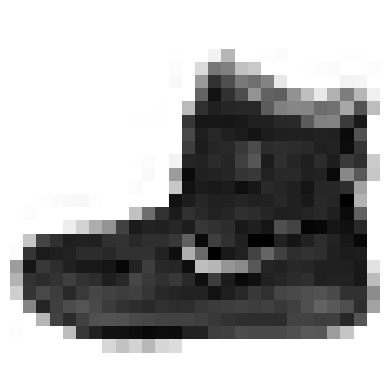

In [7]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

標籤是類別ID（表示為 uint8），從 0 到 9：

In [8]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

對於 MNIST，當標籤等於 5 時，就意味著該圖像代表手寫數字 5。很簡單。 然而，對於 Fashion MNIST，我們需要類名稱列表來了解我們正在處理的內容：

In [9]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is an ankle boot:

In [10]:
class_names[y_train[0]]

'Ankle boot'

Let's take a look at a sample of the images in the dataset:

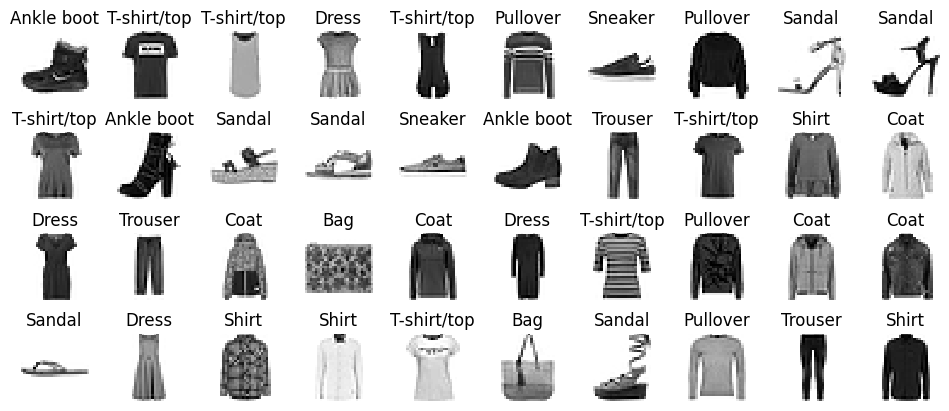

In [11]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

### Building a Classification MLP Using the Sequential API

In [12]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

* 首先，設置 TensorFloe 的隨機種子以使結果可重現。 每次運行筆記本時，隱藏層和輸出層的隨機權重都會是相同的。 還可以選擇使用 tf.keras.utils.set_ranom_seed() 函數，該函數可以方便地為 TensorFlow、Python(random.seed()) 和 Numpy(np.random.seed()) 設置隨機種子

* 下一行創建一個Sequential model。 這是最簡單的 Keras 模型，適用於僅由按順序連接的單層堆疊組成的神經網絡。 這稱為順序sequential API。

* 接下來，我們構建第一層（an Input layer）並將其添加到模型中。 我們指定輸入形狀(inpute_shape)，不包括批量大小，僅包括observation的形狀。 Keras 需要知道輸入的形狀，以便確定the shape of the connection weight matrix of the first hidden layer。 The shape of the weight matrix depends on the number of inputs. 這就是為什麼建議在Sequential model中創建第一層時指定 input_shape 的原因。 但是，如果不指定輸入形狀(有時當下不知道)，也沒關係，Keras會等到知道輸入形狀後再實際構建模型。 當向其提供實際數據（例如，在訓練期間）或調用其 build() 方法時，就會發生這種情況。 在模型真正構建之前，各層不會有任何權重，並且將無法執行某些操作（例如打印模型摘要或保存模型），因此如果在創建模型時知道輸入形狀， 最好指定一下。

* 然後添加一個 Flatten layer。 它的作用是將每個輸入圖像轉換為 D 數組：例如，如果它接收到一批形狀為 [32,28,28]，它會將其重塑為 [32,784]。 換句話說，如果它接收輸入數據 X，它就會計算 X.reshape(-1,784)。 該層沒有任何參數，只是做一些簡單的預處理。(代碼 X.reshape(-1, 784) 用於將 3 維數組 X 重塑為具有修改形狀的 2 維數組。在本例中，X 的原始形狀為 (55000, 28, 28)，這意味著它是一個包含 55,000 個樣本的 3 維數組，每個樣本的高度和寬度均為 28 個像素。通過使用 X.reshape(-1, 784)，您請求將數組 X 重塑為二維數組，其中第一個維度自動推斷 (寫-1但表自動推斷)，第二個維度設置為 784。值 784 是 由高度和寬度尺寸相乘得出 (28 * 28 = 784)。重構後的數組的形狀為 (55000, 784)，這意味著它仍然有 55,000 個樣本，但每個樣本將被展平為長度為 784 的一維數組。這通常是為某些機器準備數據 需要二維輸入的學習算法，其中每行代表一個樣本，每列代表一個特徵。)

* 接下來添加一個包含 300 個神經元的Dense hidden layer。 它將使用 ReLU activation function。 密集層管理自己的weight matrix，包含neurons及其inputs之間的所有connection weights。 它還管理vector of bias（one per neuron）

* 接下來，添加第二個包含 100 個神經元的Dense hidden layer，也使用 ReLU activation function。

* 最後，添加一個包含 10 個神經元（每個類一個）的Dense output layer，使用 softmax activation function（因為每個類是互斥的，即一個Observation只會屬於一個類，是Multiclass Classification）。

可以在創建Sequential model時傳遞層列表，而不是像上面那樣逐層添加。 還可以刪除輸入層並在第一層中指定 inut_shape：

In [13]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

模型的summary()方法顯示模型的所有層，包括每個層的名稱（除非在創建層時設置，否則會自動生成）、其輸出形狀（None表示batch size可以是任何值）及其參數數量 。 摘要為參數總數，包括可訓練和不可訓練的參數。 這裡我們只有可訓練的參數:

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


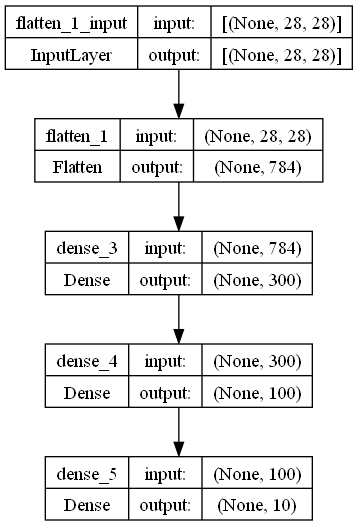

In [15]:
# another way to display the model's architecture
tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

請注意，Dense layers通常有很多參數。 例如，第一個隱藏層有 784 × 300 connection weights，加上 300 個bias項，總共有 235,500 個參數！ 這為模型提供了相當大的靈活性來擬合訓練數據，但這也意味著模型存在過度擬合的風險，特別是當您沒有大量訓練數據時。

可以輕鬆獲取模型的圖層列表，可以通過索引獲取圖層，也可以通過名稱獲取圖層：

In [16]:
model.layers

In [17]:
hidden1 = model.layers[1]
hidden1.name

'dense_3'

可以使用其 get_weights() 和 set_weights() 方法訪問層的所有參數。 例如對於Dense layer,，這包括connection weights和bias項：

In [18]:
weights, biases = hidden1.get_weights()


In [19]:
weights

array([[ 0.0586036 ,  0.07084158,  0.0279801 , ..., -0.01987296,
         0.06793679,  0.0349554 ],
       [ 0.03998481, -0.07217473, -0.06721105, ..., -0.0696543 ,
        -0.03450678,  0.00110833],
       [-0.01570836,  0.04751027,  0.00850365, ..., -0.0674832 ,
        -0.01039023, -0.06143486],
       ...,
       [ 0.00680107,  0.01778367, -0.02156708, ...,  0.07285258,
         0.04522995, -0.03420885],
       [-0.03847025,  0.0719512 , -0.03835845, ...,  0.01072392,
        -0.03809383,  0.0178319 ],
       [ 0.01608928, -0.02304222,  0.07231884, ..., -0.04005373,
         0.06001946, -0.06744317]], dtype=float32)

In [20]:
weights.shape

(784, 300)

In [21]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [22]:
biases.shape

(300,)

請注意，Dense layer隨機初始化connection weights（這是打破對稱性所必需的，造就多樣化），並且biases初始化為零，這樣沒問題。 如果想使用不同的初始化方法，可以在創建層時設置 kernel_initializer （kernel 是connection weights矩陣的另一個名稱）或bias_initializer。 如果想要完整列表，請參閱 https://keras.io/api/layers/initializers/

### Compiling the Model

創建模型後，必須調用其compile()方法來指定 loss function和要使用的優化器(optimizer)。 或者，還可以指定在訓練和評估期間要計算的額外指標列表：

In [23]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

In [24]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

* 使用“sparse_categorical_crossen tropy” loss，因為有稀疏標籤sparse labels (即class indices，對於每個observation只有一個target，在本例中為 0 到 9)，並且這些類是互斥的。 相反，如果每個observation的每個類都有一個目標概率(例如one-hot vectors，像是[0., 0., 0., 1., 0., 0., 0., 0., 0., 0 .] 來表示類別 3)，那麼需要使用“categorical_crossentropy” loss來代替。 如果正在進行二元分類（具有一個或多個二元標籤），那麼將在輸出層中使用“sigmoid”（即邏輯）activation function,而不是“softmax”activation function,，並且將使用“binary_crossentropy” loss。

* 如果要將sparse labels（即class indices）轉換為 one-hot 向量標籤，可以使用 keras.utils.to_categorical() 函數。 反之亦然，將 one-hot 向量標籤轉換為sparse labels可以使用帶有 axis=1 的 np.arg max() 函數。

* 關於優化器，“sgd”意味著將使用隨機梯度下降來訓練模型。 換句話說，Keras 將執行backpropagation algorithm（即reverse-mode autodiff + Gradient Descent）。有更高效的優化器（它們改進梯度下降部分，而不是改進自動差分）。 

* 使用 SGD 優化器時，調整學習率非常重要。 因此，通常會希望使用 optimizationr=tf.keras.optimizers.SGD(learning_rate=__???__) 來設置學習率，而不是 optimizer="sgd"，後者默認學習率為 0.01。

* 最後，由於這是一個分類器，因此在訓練和評估期間測量其“accuracy”。

### Training and evaluating the model

現在模型已準備好接受訓練。 為此，我們只需要調用它的 fit() 方法。

輸入特徵 (X_train) 和目標類 (y_train)，以及要訓練的 epoch 數（否則它將默認為 1，這肯定不足以收斂到一個好的解決方案）。 還輸入一個驗證集（這是optional的）：Keras 將在每個 epoch 結束時測量該驗證集的loss 和extra metrics，這對於查看模型的實際性能非常有用：如果訓練的性能比驗證集好得多，模型可能過度擬合訓練集（或者存在錯誤，例如訓練集和驗證集之間的數據不匹配）。(可以將validation_split 設置為希望Keras 用於驗證的訓練集的比率，而不是使用validation_data 參數傳遞驗證集。 例如，validation_split=0.1 告訴 Keras 使用最後 10% 的數據（before shuffling）進行驗證。)

In [25]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 5s 2ms/step - loss: 0.7181 - sparse_categorical_accuracy: 0.7639 - val_loss: 0.5041 - val_sparse_categorical_accuracy: 0.8304
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4852 - sparse_categorical_accuracy: 0.8333 - val_loss: 0.4555 - val_sparse_categorical_accuracy: 0.8374
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4390 - sparse_categorical_accuracy: 0.8465 - val_loss: 0.4191 - val_sparse_categorical_accuracy: 0.8548
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4143 - sparse_categorical_accuracy: 0.8561 - val_loss: 0.3928 - val_sparse_categorical_accuracy: 0.8620
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3942 - sparse_categorical_accuracy: 0.8621 - val_loss: 0.3884 - val_sparse_categorical_accuracy: 0.8602
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3782 - spars

神經網絡已訓練完畢。 在訓練期間的每個時期，Keras 在進度條的左側顯示迄今為止處理的mini-batches的數量。 默認情況下，批量大小為 32，由於訓練集有 55000 張圖像，因此模型每個 epoch 會經歷 1719 個批次（118 個大小為 32 的批次和 1 個大小為 24 的批次）。 在進度條之後，可以看到訓練集和驗證集上每個樣本的平均訓練時間、損失和accuracy（或要求的任何其他額外指標）。 可以看到training loss下降了，這是一個好兆頭，30 個 epoch 後驗證accuracy達到 88.98%。 這略低於訓練accuracy，因此存在一點過度擬合，但不是很大。

如果訓練集非常skewed，某些類別的代表性過高，而另一些類別的代表性不足，則在調用 fit() 方法時設置 class_weight 參數會很有用，以便為代表性不足的類別提供較大的權重，為代表性過高的類別提供較低的權重。 Keras 在計算損失時將使用這些權重。 如果需要per-instance weights，設置sample_weight參數。 如果同時提供了class_weight和sample_weight，那麼Keras會將它們相乘。 per-instance weights可能會很有用，例如，如果某些實例由專家標記，而其他實例則使用眾包平台標記：可能希望給予前者更多的權重。 還可以通過將sample weights添加為validation_data中的第三項來為驗證集提供樣本權重（但不是class weights）。

fit() 方法返回一個 History object，其中包含訓練參數 (history.params)、the list of epochs it went through(history.epoch)，以及最重要的一個包含在訓練集和驗證集（如果有）的每個時期結束時的loss和extra metrics 的字典 (history.history)。 如果使用這個字典創建一個 Pandas DataFrame 並調用它的plot()方法，會得到學習曲線：

In [26]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [27]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


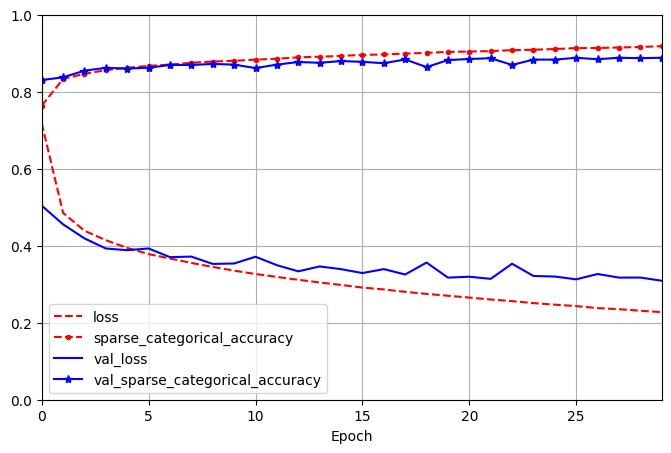

In [28]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
plt.show()

可以看到，訓練過程中訓練準確率和驗證準確率都穩步上升，而訓練損失和驗證損失則下降。 這很好。 驗證曲線一開始彼此相對接近，但隨著時間的推移，它們的距離越來越遠，這表明存在一點過度擬合。 在這種特殊情況下，模型在訓練開始時看起來在驗證集上的表現比在訓練集上的表現更好，但實際情況並非如此。 驗證誤差是在每個 epoch 結束時計算的，而訓練誤差是使用每個 epoch 期間的運行平均值計算的，因此訓練曲線應向左移動半個 epoch。 如果這樣做，將看到訓練曲線和驗證曲線在訓練開始時幾乎完美重疊。訓練集的性能最終會超過驗證性能，當訓練足夠長的時間時通常會出現這種情況。 可以看出模型尚未完全收斂，因為驗證損失仍在下降，因此可能應該繼續訓練。 這就像再次調用 fit() 方法一樣簡單，因為 Keras 只是在停止的地方繼續訓練。

如果對模型的性能不滿意，應該返回並調整超參數。 第一個要檢查的是學習率。 如果這沒有幫助，請嘗試另一個優化器（並且在更改任何超參數後始終重新調整學習率）。 如果性能仍然不是很好，則嘗試調整模型參數，例如層數、每層神經元數量以及每個隱藏層使用的activation functions類型。 還可以嘗試調整其他超參數，例如批量大小（可以使用 batch_size 參數在 fit() 方法中設置，默認為 32）。  

一旦對模型的驗證準確性感到滿意，應該在測試集上對其進行評估，以估計泛化誤差，然後再將模型部署到生產中。 可以使用evaluate（）方法輕鬆地做到這一點（它還支持其他幾個參數，例如batch_size和sample_weight；請查看文檔以了解更多詳細信息）：

In [29]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 2ms/step - loss: 0.3250 - sparse_categorical_accuracy: 0.8829


[0.3249576687812805, 0.8828999996185303]

測試集上的性能通常比驗證集上的性能稍低，因為超參數是在驗證集上調整的（但是，在本例中，我們沒有調參數，因此較低的精度只是運氣不好）。 請記住抵制調整測試集上的超參數的誘惑，否則對泛化誤差的估計將過於樂觀。

### Using the model to make predictions

現在讓我們使用模型的predict()方法對新實例進行預測。 由於我們沒有實際的新實例，因此我們將僅使用測試集的前三個實例：

In [30]:
X_new = X_test[:3]

In [31]:
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 75ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.97],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

對於第一張圖像，它估計類別 9（踝靴）的概率為 97%，類別 7（運動鞋）的概率為 2%。 換句話說，高度確信第一張圖像是類別 9（踝靴），但也可能是類別 7（運動鞋）。 如果只關心估計概率最高的類（即使該概率非常低），那麼可以使用 argmax() 方法來獲取每個實例的最高概率類索引：

In [32]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1], dtype=int64)

In [33]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

Here, the classifier actually classified all three images correctly

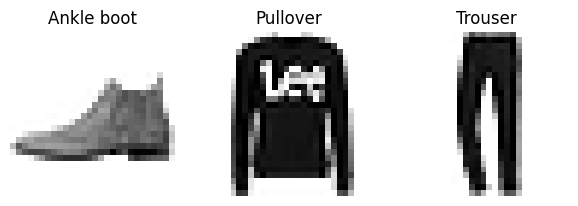

In [34]:
y_new = y_test[:3]
y_new
# extra code – this cell generates and saves Figure 10–12
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Building a Regression MLP Using the Sequential API

使用sequential API來構建、訓練、評估和使用回歸 MLP 與我們對分類所做的非常相似。 以下代碼示例中的主要區別在於輸出層具有單個神經元（因為我們只想預測單個值）並且它不使用activation function，loss function是mean squared error，度量(metric)是 RMSE，使用 Adam 優化器。 此外，在本例中，不需要 Flatten 層，而是使用 Normalization 層作為第一層：它與 Scikit-Learn 的 StandardScaler 執行相同的操作，但必須使用其功能來擬合訓練數據。 在調用模型的 fit() 方法之前先調用 adapt() 方法。 （Keras也還有其他預處理層preprocessing layers）。 

In [35]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [36]:
X_train

array([[   3.5214    ,   15.        ,    3.04994451, ...,    1.60599334,
          37.63      , -122.43      ],
       [   5.3275    ,    5.        ,    6.49005964, ...,    3.44333996,
          33.69      , -117.39      ],
       [   3.1       ,   29.        ,    7.54237288, ...,    2.25084746,
          38.44      , -122.98      ],
       ...,
       [   1.5561    ,   35.        ,    4.13993174, ...,    3.27645051,
          34.11      , -117.29      ],
       [   2.1055    ,   52.        ,    5.17849462, ...,    2.92688172,
          36.76      , -119.79      ],
       [   5.6022    ,   31.        ,    6.21971253, ...,    2.53798768,
          38.04      , -122.2       ]])

In [37]:
y_train

array([1.442, 1.687, 1.621, ..., 0.68 , 0.613, 1.97 ])

In [38]:
X_new = X_test[:3]

In [39]:
X_train.shape, X_train.shape[1:]#通過shape[1:]，將選擇除第一個維度之外的所有維度，第一個維度通常表示observation數量(row的數量)。

((11610, 8), (8,))

In [40]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test, rmse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 2ms/step - loss: 0.9871 - root_mean_squared_error: 0.9935 - val_loss: 0.5558 - val_root_mean_squared_error: 0.7455
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3865 - root_mean_squared_error: 0.6217 - val_loss: 0.8415 - val_root_mean_squared_error: 0.9173
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3541 - root_mean_squared_error: 0.5951 - val_loss: 0.5585 - val_root_mean_squared_error: 0.7473
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3430 - root_mean_squared_error: 0.5856 - val_loss: 0.6621 - val_root_mean_squared_error: 0.8137
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3312 - root_mean_squared_error: 0.5755 - val_loss: 0.5438 - val_root_mean_squared_error: 0.7374
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3198 - root_mean_squared_error: 0.5655 - val_loss: 0.3231 - val_

當調用 Adapt() 方法時，Normalization layer會學習訓練數據中的特徵均值和標準差。 然而，當顯示模型的摘要時，這些統計數據被列為不可訓練。 這是因為這些參數不受梯度下降的影響。

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 8)                17        
 n)                                                              
                                                                 
 dense_6 (Dense)             (None, 50)                450       
                                                                 
 dense_7 (Dense)             (None, 50)                2550      
                                                                 
 dense_8 (Dense)             (None, 50)                2550      
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5,618
Trainable params: 5,601
Non-trainable params: 17
___________________________________________________

In [42]:
rmse_test

0.5325239896774292

In [43]:
y_pred

array([[0.48347446],
       [1.113864  ],
       [5.060088  ]], dtype=float32)

## Building Complex Models Using the Functional API

Sequential API 非常乾淨和簡單。 然而，儘管順序模型非常常見，但有時構建具有更複雜或具有多個輸入或輸出的神經網絡很有用。 為此，Keras 提供了the functional API。

you can build all sorts of architectures with the functional API，以下使用Wide & Deep 神經網絡示範

### Wide & Deep neural network

nonsequential neural network 的一個例子是 Wide & Deep 神經網絡。 它將全部或部分輸入直接連接到輸出層。 這種架構使神經網絡能夠學習深層模式（using the deep path）和簡單規則（through the short path）。⁠相反，常規 MLP 強制所有數據流經完整的layers ; 因此，數據中的簡單模式最終可能會因這一系列轉換而被扭曲。

構建這樣一個神經網絡來解決加州的住房問題：

In [44]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()#reset the name counters
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 normalization (Normalization)  (None, 8)            17          ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 30)           270         ['normalization[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 30)           930         ['dense[0][0]']                  
                                                                                              

In [46]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
normalization_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 2ms/step - loss: 1.2187 - root_mean_squared_error: 1.1040 - val_loss: 0.8406 - val_root_mean_squared_error: 0.9169
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4595 - root_mean_squared_error: 0.6779 - val_loss: 1.0090 - val_root_mean_squared_error: 1.0045
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3948 - root_mean_squared_error: 0.6283 - val_loss: 0.5057 - val_root_mean_squared_error: 0.7111
Epoch 4/20
363/363 [==============================] - 1s 1ms/step - loss: 0.3698 - root_mean_squared_error: 0.6081 - val_loss: 0.8238 - val_root_mean_squared_error: 0.9076
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3597 - root_mean_squared_error: 0.5998 - val_loss: 2.1870 - val_root_mean_squared_error: 1.4789
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3632 - root_mean_squared_error: 0.6027 - val_loss: 1.6211 - val_

前五行創建了構建模型所需的所有層，接下來的六行像函數一樣從輸入到輸出使用這些層，最後一行創建一個 Keras Model。

* 首先，創建五個層：一個用於標準化輸入的Normalization layer、兩個使用 ReLU activation function且每層有 30 個神經元的Dense layer 、一個連接層 Concatenate layer以及一個用於output layer，具有單個神經元的Dense layer，沒有任何activation function。

* 接下來，創建一個 Input 對象（變量名 input_ 用於避免與 Python 的內置 input() 函數重疊）。 這是模型將獲得的輸入類型的規範，包括其形狀和可選的 dtype，默認為 32 位浮點數(一個模型實際上可能有多個輸入)。

* 然後像函數一樣使用Normalization laye。 這就是為什麼這被稱為functional API。 請注意，只是告訴 Keras 應該如何將各層連接在一起； 尚未處理任何實際數據，因為輸入對像只是一個數據規範。  此調用的輸出也是像徵性的，僅用於構建模型。

* 以同樣的方式，將normalized傳遞給hidden_layer1，它輸出hidden1，然後我們將hidden1傳遞給hidden_layer2，它輸出hidden2。

* 到目前為止，已經按順序連接了各層，但隨後使用 concat_layer 連接輸入和第二個隱藏層的輸出。 同樣，還沒有連接任何實際數據：構建模型時這一切都是像徵性的。

* 最後，創建一個 Keras 模型，指定要使用的輸入和輸出。

一旦構建了 Keras 模型，一切都與之前一模一樣：compile the model, train it, evaluate it and use it to make predictions.

### 多輸入單輸出

但是，如果想send a subset of the features through the wide path and a different subset (可能有重疊) through the deep path，該怎麼辦？ 在這種情況下，一種解決方案是使用多個輸入。 例如，假設要通過寬路徑發送 5 個特徵（特徵 0 到 4），通過深度路徑發送 6 個特徵（特徵 2 到 7），可以這樣做：

In [47]:
tf.keras.backend.clear_session()#reset the name counters
tf.random.set_seed(42)
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [48]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 normalization_1 (Normalization  (None, 6)           13          ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 input_1 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 30)           210         ['normalization_1[0][0]']    

與上一個範例相比，此範例有以下幾點需要注意：

* 每個 Dense 層都是在同一行上創建和調用的。 這是一種常見的做法，因為它使代碼更加簡潔而不失清晰度。(無法使用標準化層執行此操作，因為我們需要有該層的reference才能在擬合模型之前調用其 Adapt() 方法)

* 使用 tf.keras.layers.concatenate()，它創建一個 Concatenate 層

* 在創建模型時指定輸入=[input_wide, input_deep]，因為有兩個輸入。

現在可以像往常一樣編譯模型，但是當調用 fit() 方法時，必須傳遞一對矩陣（X_train_wide、X_train_deep），而不是傳遞單個輸入矩陣 X_train。 對於 X_valid 也是同樣的情況，當調用 evaluate() 或 Predict() 時，對於 X_test 和 X_new 也是如此：

In [49]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20,
                    validation_data=((X_valid_wide, X_valid_deep), y_valid))
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.3253 - root_mean_squared_error: 1.1512 - val_loss: 0.6066 - val_root_mean_squared_error: 0.7788
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4975 - root_mean_squared_error: 0.7053 - val_loss: 0.7687 - val_root_mean_squared_error: 0.8768
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4336 - root_mean_squared_error: 0.6584 - val_loss: 0.5327 - val_root_mean_squared_error: 0.7298
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4089 - root_mean_squared_error: 0.6394 - val_loss: 0.4485 - val_root_mean_squared_error: 0.6697
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4027 - root_mean_squared_error: 0.6346 - val_loss: 1.7514 - val_root_mean_squared_error: 1.3234
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3926 - root_mean_squared_error: 0.6265 - val_loss: 0.5809 - val_

### 多輸入多輸出

還有許多情況可能希望擁有多個輸出(multiple outputs)：

* 任務可能需求。 For instance, you may want to locate and classify the main object in a picture. This is both a regression tasks and a classification task.

* 同樣，可能有多個基於相同數據的獨立任務。 當然，可以為每個任務訓練一個神經網絡，但在許多情況下，通過訓練每個任務一個輸出的單個神經網絡，將在所有任務上獲得更好的結果。 這是因為神經網絡可以學習數據中跨任務有用的特徵。 例如，可以對面部圖片執行多任務分類，使用一個輸出對人的面部表情（微笑、驚訝等）進行分類，並使用另一個輸出來識別他們是否戴眼鏡。

* 另一個用例是作為正則化技術（即，訓練約束，其目標是減少過度擬合，從而提高模型的泛化能力）。 例如，可能希望在神經網絡架構中添加輔助輸出(auxiliary output)，以確保網絡的底層部分自行學習有用的東西，而不依賴於網絡的其餘部分。


添加額外的輸出非常簡單，只需將其連接到適當的層並將其添加到模型的輸出列表中，例如建構一個添加auziliary output的網絡:

In [50]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [51]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep],
                       outputs=[output, aux_output])

In [52]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
              metrics=["RootMeanSquaredError"])

In [53]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=20,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid))
)

Epoch 1/20
363/363 [==============================] - 2s 3ms/step - loss: 1.5628 - dense_2_loss: 1.4633 - dense_3_loss: 2.4581 - dense_2_root_mean_squared_error: 1.2097 - dense_3_root_mean_squared_error: 1.5678 - val_loss: 1.4232 - val_dense_2_loss: 1.2374 - val_dense_3_loss: 3.0955 - val_dense_2_root_mean_squared_error: 1.1124 - val_dense_3_root_mean_squared_error: 1.7594
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5732 - dense_2_loss: 0.5437 - dense_3_loss: 0.8382 - dense_2_root_mean_squared_error: 0.7374 - dense_3_root_mean_squared_error: 0.9155 - val_loss: 0.9788 - val_dense_2_loss: 0.9701 - val_dense_3_loss: 1.0570 - val_dense_2_root_mean_squared_error: 0.9850 - val_dense_3_root_mean_squared_error: 1.0281
Epoch 3/20
363/363 [==============================] - 1s 1ms/step - loss: 0.4781 - dense_2_loss: 0.4574 - dense_3_loss: 0.6649 - dense_2_root_mean_squared_error: 0.6763 - dense_3_root_mean_squared_error: 0.8154 - val_loss: 0.4710 - val_dense_2_loss

當評估模型時，Keras 返回損失的加權和，以及所有單獨的損失和指標：

In [54]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test), return_dict=True)
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results

162/162 [==============================] - 0s 1ms/step - loss: 0.3405 - dense_2_loss: 0.3337 - dense_3_loss: 0.4014 - dense_2_root_mean_squared_error: 0.5777 - dense_3_root_mean_squared_error: 0.6336


predict() 方法將返回每個輸出的預測：

In [55]:

y_pred_tuple = model.predict((X_new_wide, X_new_deep))
y_pred = dict(zip(model.output_names, y_pred_tuple))
y_pred

1/1 [==============================] - 0s 63ms/step


{'dense_2': array([[0.47514242],
        [1.0576235 ],
        [3.4449148 ]], dtype=float32),
 'dense_3': array([[0.6922744],
        [1.12455  ],
        [3.091931 ]], dtype=float32)}

## Using the Subclassing API to Build Dynamic Models

對 Model 類進行subclass，在構造中創建所需的層，並使用 call() 方法執行所需的計算。 

例如，創建以下 WideAndDeepModel class提供了一個與使用functional API 構建的模型等效的模型：

In [56]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs): #The **kwargs parameter allows additional keyword arguments to be passed to the constructor, 
                                                               #which can be useful for customization or compatibility with other code.
        super().__init__(**kwargs)  # needed to support naming the model. #The super().__init__(**kwargs) line calls the constructor 
                                    #of the parent class (tf.keras.Model) to initialize the inherited attributes and functionality. 
                                    #The **kwargs syntax is used to pass any additional keyword arguments to the parent class.
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)
        
    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output

tf.random.set_seed(42)  # extra code – just for reproducibility
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

將構造函數中層的創建與 call() 方法中層的使用分開，且不需與Sequential API和functional API創建一樣Input objects，可以使用 call() 方法輸入參數。Now that we have a model instance, we can compile it, adapt its normalization layers (e.g., using model.norm_layer_wide.adapt(...) and model.norm_​layer_deep.adapt(...)), fit it, evaluate it, and use it to make predictions, exactly like we did with the functional API.

In [57]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=optimizer,
              metrics=["RootMeanSquaredError"])
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)))
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

Epoch 1/10
363/363 [==============================] - 2s 2ms/step - loss: 1.6980 - output_1_loss: 1.5695 - output_2_loss: 2.8541 - output_1_root_mean_squared_error: 1.2528 - output_2_root_mean_squared_error: 1.6894 - val_loss: 2.9329 - val_output_1_loss: 0.7915 - val_output_2_loss: 22.2061 - val_output_1_root_mean_squared_error: 0.8897 - val_output_2_root_mean_squared_error: 4.7123
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6999 - output_1_loss: 0.6622 - output_2_loss: 1.0396 - output_1_root_mean_squared_error: 0.8138 - output_2_root_mean_squared_error: 1.0196 - val_loss: 2.0075 - val_output_1_loss: 1.0816 - val_output_2_loss: 10.3406 - val_output_1_root_mean_squared_error: 1.0400 - val_output_2_root_mean_squared_error: 3.2157
Epoch 3/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5570 - output_1_loss: 0.5410 - output_2_loss: 0.7002 - output_1_root_mean_squared_error: 0.7356 - output_2_root_mean_squared_error: 0.8368 - val_loss: 1.0

這個 API 的最大區別在於，可以在 call() 方法中包含幾乎任何想要的東西：for 循環、if 語句、low-level TensorFlow操作——想像力是無限的！ 這使得它在嘗試新想法時成為一個很棒的 API，特別是對於研究人員而言。 然而，這種額外的靈活性確實是有代價的：模型的架構隱藏在 call() 方法中，因此 Keras 無法輕鬆檢查它； 無法使用 tf.keras.models.clone_model() 克隆模型； 當調用summary()方法時，只會得到一個層列表，而沒有任何關於它們如何相互連接的信息。 而且Keras無法提前檢查類型和形狀，更容易出錯。 因此，除非確實需要額外的靈活性，否則應該使用sequential API 或 functional API。

## Saving and Restoring a Model

保存經過訓練的 Keras 模型非常簡單：

In [58]:
# extra code – delete the directory, in case it already exists

import shutil

shutil.rmtree("my_keras_model", ignore_errors=True)

In [59]:
model.save("my_keras_model", save_format="tf")

INFO:tensorflow:Assets written to: my_keras_model\assets


INFO:tensorflow:Assets written to: my_keras_model\assets


In [60]:
#show the contents of the my_keras_model/ directory
for path in sorted(Path("my_keras_model").glob("**/*")):
    print(path)

my_keras_model\assets
my_keras_model\fingerprint.pb
my_keras_model\keras_metadata.pb
my_keras_model\saved_model.pb
my_keras_model\variables
my_keras_model\variables\variables.data-00000-of-00001
my_keras_model\variables\variables.index


當設置 save_format="tf" 時，Keras 使用 TensorFlow 的 SavedModel 格式保存模型：這是一個包含多個文件和子目錄的目錄（具有給定名稱）。 特別是，saved_model.pb 文件以序列化計算圖的形式包含模型的架構和邏輯，因此部署時無需模型的源代碼即可在生產中使用它，只需要SavedModel 就足夠了。 keras_metadata.pb 文件包含 Keras 所需的額外信息。 variables子目錄包含所有參數值（包括連接權重、偏差、歸一化統計數據和優化器參數），如果模型非常大，可能會拆分為多個文件。 最後，assets目錄可以包含額外的文件，例如數據樣本、特徵名稱、類名稱等(默認情況下，assets目錄為空)。 由於優化器也被保存，包括它的超參數和它可能具有的任何狀態，加載模型後，如果需要，可以繼續訓練。

通常會擁有一個用於訓練模型並保存模型的script，以及一個或多個用於加載模型並使用它來評估模型或進行預測的script（或 Web 服務）。 

加載模型與保存模型一樣簡單：

In [61]:
model = tf.keras.models.load_model("my_keras_model")
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 107ms/step


還可以使用 save_weights() 和 load_weights() 僅保存和加載參數值。 這包括connection weights、biases、預處理統計信息、optimizer等。參數值保存在一個或多個文件（例如 my_weights.data-00004-of-00052）以及一個索引文件（例如 my_weights.index）中。

In [62]:
model.save_weights("my_weights")

In [63]:
model.load_weights("my_weights")

In [64]:
#show the list of my_weights.* files
for path in sorted(Path().glob("my_weights.*")):
    print(path)

my_weights.data-00000-of-00001
my_weights.index


與保存整個模型相比，僅保存權重速度更快，佔用的磁盤空間更少，因此在訓練期間保存快速檢查點(checkpoints)是完美的選擇。 如果正在訓練大型模型，並且需要數小時或數天，那麼必須定期保存checkpoints，以防計算機崩潰。 但是如何告訴 fit() 方法保存checkpoints呢？ 使用callbacks。

## Using Callbacks

fit() 方法接受一個回調參數，可以指定 Keras 在訓練之前和之後、每個 epoch 之前和之後、甚至在處理每個batch之前和之後調用一個列表。 例如，ModelCheckpoint 回調在訓練期間定期保存模型的checkpoints默認情況下在每個epoch結束時保存：

In [65]:
shutil.rmtree("my_checkpoints", ignore_errors=True)  # extra code。請記住，此代碼會永久刪除指定的目錄及其內容。使用此代碼時要小心，以避免意外刪除重要數據。

In [66]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",
                                                   save_weights_only=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb])

Epoch 1/10


363/363 [==============================] - 3s 3ms/step - loss: 0.3716 - output_1_loss: 0.3630 - output_2_loss: 0.4493 - output_1_root_mean_squared_error: 0.6025 - output_2_root_mean_squared_error: 0.6703 - val_loss: 0.3890 - val_output_1_loss: 0.3826 - val_output_2_loss: 0.4471 - val_output_1_root_mean_squared_error: 0.6185 - val_output_2_root_mean_squared_error: 0.6687
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.3551 - output_1_loss: 0.3459 - output_2_loss: 0.4379 - output_1_root_mean_squared_error: 0.5881 - output_2_root_mean_squared_error: 0.6617 - val_loss: 0.7191 - val_output_1_loss: 0.7275 - val_output_2_loss: 0.6435 - val_output_1_root_mean_squared_error: 0.8529 - val_output_2_root_mean_squared_error: 0.8022
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.3619 - output_1_loss: 0.3544 - output_2_loss: 0.4294 - output_1_root_mean_squared_error: 0.5953 - output_2_root_mean_squared_error: 0.6553 - val_loss: 0.3962 - val_out

此外，如果在訓練期間使用驗證集，則可以在創建 ModelCheckpoint 時設置 save_​best_only=True。 在這種情況下，只有當模型在驗證集上的性能迄今為止最好時，它才會保存模型。 這樣就不必擔心訓練時間過長和訓練集過擬合：只需在訓練後恢復上次保存的模型，這將是驗證集上的最佳模型。 這是實現early stopping的一種方法，但它實際上不會停止訓練而是保存最佳模型後繼續訓練下去。

另一種方法是使用 EarlyStopping callback。 當它測量到驗證集在多個時期（defined by the "patience" argument）沒有進展時，它將中斷訓練，並且如果設置restore_best_weights=True，它將在訓練結束時回到最佳模型。 可以結合使用這兩個回調來保存模型的檢查點，以防計算機崩潰，並在沒有更多進展時儘早中斷訓練，以避免浪費時間和資源並減少過度擬合：

In [67]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=100,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3423 - output_1_loss: 0.3360 - output_2_loss: 0.3984 - output_1_root_mean_squared_error: 0.5797 - output_2_root_mean_squared_error: 0.6312 - val_loss: 1.0935 - val_output_1_loss: 1.1726 - val_output_2_loss: 0.3814 - val_output_1_root_mean_squared_error: 1.0829 - val_output_2_root_mean_squared_error: 0.6176
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3418 - output_1_loss: 0.3361 - output_2_loss: 0.3934 - output_1_root_mean_squared_error: 0.5797 - output_2_root_mean_squared_error: 0.6272 - val_loss: 1.0145 - val_output_1_loss: 1.0015 - val_output_2_loss: 1.1312 - val_output_1_root_mean_squared_error: 1.0008 - val_output_2_root_mean_squared_error: 1.0636
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3358 - output_1_loss: 0.3295 - output_2_loss: 0.3918 - output_1_root_mean_squared_error: 0.5741 - output_2_root_mean_squared_error: 0.6259 - val_loss: 0.

keras.callbacks 包中還有許多其他可用的回調，參閱 https://keras.io/callbacks/

如果需要額外的控制，可以輕鬆編寫自定義callback。 例如，以下自定義回調將顯示訓練期間驗證損失和訓練損失之間的比率（用來檢測是否過度擬合）：

In [68]:
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        ratio = logs["val_loss"] / logs["loss"]
        print(f"Epoch={epoch}, val/train={ratio:.2f}")

In [69]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[val_train_ratio_cb], verbose=0)

Epoch=0, val/train=1.33
Epoch=1, val/train=0.97
Epoch=2, val/train=2.13
Epoch=3, val/train=4.36
Epoch=4, val/train=9.95
Epoch=5, val/train=2.91
Epoch=6, val/train=2.24
Epoch=7, val/train=1.19
Epoch=8, val/train=1.76
Epoch=9, val/train=0.95


As you might expect, you can implement on_train_begin(), on_train_end(), on_epoch_begin(), on_epoch_end(), on_batch_begin(), and on_batch_end(). Callbacks can also be used during evaluation and predictions, should you ever need them (e.g., for debugging). For evaluation, you should implement on_test_begin(), on_test_end(), on_test_batch_begin(), or on_test_batch_end(), which are called by evaluate(). For prediction, you should implement on_predict_begin(), on_predict_end(), on_predict_batch_begin(), or on_predict_batch_end(), which are called by predict().

## Using TensorBoard for Visualization

TensorBoard 是一款出色的交互式可視化工具，可以使用它來查看訓練期間的學習曲線、比較多次運行之間的曲線和指標、可視化計算圖、分析訓練統計數據、查看模型生成的圖像、投影到複雜多維數據到3D並可是化、自動聚類、分析網絡（即測量其速度以識別瓶頸）等等！

當安裝 TensorFlow 時，TensorBoard 會自動安裝。 但是，需要 TensorBoard 插件來可視化分析數據。

In [13]:
if "google.colab" in sys.modules:  # extra code
    %pip install -q -U tensorboard-plugin-profile

要使用 TensorBoard，必須修改program，以便將想要可視化的數據輸出到稱為event files的特殊二進制日誌文件(binary logfiles )。 每個binary data記錄稱為summary。 TensorBoard 服務器將監視日誌目錄，並自動偵測變動，更新可視化：這使你可以可視化實時數據（有短暫的延遲），例如訓練期間的學習曲線。 一般來說，希望將 TensorBoard 服務器指向root日誌目錄並配置程序，以便它每次運行時都會寫入不同的子目錄。 這樣，同一個 TensorBoard 服務器將允許可視化和比較多次運行程序的數據，而不會混淆所有內容。

將根日誌目錄命名為 my_logs，並定義一個小函數，根據當前日期和時間生成日誌子目錄的路徑，以便每次運行時都不同：

In [26]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()

In [27]:
#builds the first regression model we used earlier
tf.keras.backend.clear_session()
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model2 = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.003)
model2.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)

好消息是 Keras 提供了一個方便的 TensorBoard() callback，它將負責創建日誌目錄（如果需要，還可以創建parent directories），並且它將創建event files並在訓練期間向其中寫入摘要。 它將測量模型的訓練和驗證損失和指標（在本例中為 MSE 和 RMSE），並且還將分析神經網絡。 使用起來很簡單：

In [28]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                profile_batch=(100, 200))
history = model2.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb])

Epoch 1/20
1719/1719 [==============================] - 4s 2ms/step - loss: 8.5848 - root_mean_squared_error: 2.9300 - val_loss: 8.4540 - val_root_mean_squared_error: 2.9078
Epoch 2/20
1719/1719 [==============================] - 3s 2ms/step - loss: 8.3110 - root_mean_squared_error: 2.8829 - val_loss: 8.4061 - val_root_mean_squared_error: 2.8995
Epoch 3/20
1719/1719 [==============================] - 4s 2ms/step - loss: 8.2786 - root_mean_squared_error: 2.8773 - val_loss: 8.4838 - val_root_mean_squared_error: 2.9128
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 8.2664 - root_mean_squared_error: 2.8751 - val_loss: 8.4323 - val_root_mean_squared_error: 2.9040
Epoch 5/20
1719/1719 [==============================] - 4s 2ms/step - loss: 8.2623 - root_mean_squared_error: 2.8744 - val_loss: 8.3757 - val_root_mean_squared_error: 2.8943
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 8.2562 - root_mean_squared_error: 2.8734 - val_loss: 8

在此示例中，它將在第一個 epoch 期間分析批次 100 和批次 200 之間的網絡。 為什麼是100和200？ 神經網絡通常需要幾個批次才能“warm up”，因此不想太早進行分析，並且分析會佔用資源，因此最好不要對每個批次都進行分析。

每次更改網絡的某個部分(例如直接將學習率從 0.001 更改為 0.005)，再次運行代碼，將得到與此類似的目錄結構：

In [29]:
print("my_logs")
for path in sorted(Path("my_logs").glob("**/*")):
    print("  " * (len(path.parts) - 1) + path.parts[-1])

my_logs
  run_2023_06_27_10_30_06
    plugins
      profile
        2023_06_27_02_30_32
          BLUEDREAMV1B3.xplane.pb
    train
      events.out.tfevents.1687833031.BLUEDREAMV1B3.8980.33.v2
    validation
      events.out.tfevents.1687833034.BLUEDREAMV1B3.8980.34.v2
  run_2023_06_27_10_34_00
    plugins
      profile
        2023_06_27_02_34_05
          BLUEDREAMV1B3.xplane.pb
    train
      events.out.tfevents.1687833244.BLUEDREAMV1B3.8980.35.v2
    validation
      events.out.tfevents.1687833248.BLUEDREAMV1B3.8980.36.v2


每次運行有一個目錄，每個目錄包含一個用於訓練日誌的子目錄和一個用於驗證日誌的子目錄。 兩者都包含event files，訓練日誌還包含分析跟踪。

現在已準備好event files，是時候啟動 TensorBoard 服務器了。 


In [33]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 20068), started 14:02:20 ago. (Use '!kill 20068' to kill it.)

if prefer to access TensorBoard in a separate tab, click the "localhost:6006" link below:

In [25]:

from IPython.display import display, HTML

display(HTML('<a href="http://localhost:6006/">http://localhost:6006/</a>'))

此外，TensorFlow 在 tf.summary 包中提供了較低級別的 API。 以下代碼使用 create_file_writer() 函數創建一個 SummaryWriter，並使用該 writer 作為 Python 上下文來記錄標量、直方圖、圖像、音頻和文本，然後所有這些都可以使用 TensorBoard 進行可視化(如果運行此代碼並單擊 TensorBoard 中的刷新按鈕，將看到出現幾個選項卡：IMAGES, AUDIO, DISTRIBUTIONS, HISTOGRAMS, and TEXT)：

In [31]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(str(test_logdir))
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        
        data = (np.random.randn(100) + 2) * step / 100  # gets larger
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        
        images = np.random.rand(2, 32, 32, 3) * step / 1000  # gets brighter
        tf.summary.image("my_images", images, step=step)
        
        texts = ["The step is " + str(step), "Its square is " + str(step ** 2)]
        tf.summary.text("my_text", texts, step=step)
        
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

## Fine-Tuning Neural Network Hyperparameters

可以使用 Keras Tuner 庫，它是 Keras 模型的參數調整庫。 它提供了多種tuning strategies，highly customizable，並且與 TensorBoard 具有出色的integration。

In [6]:
#In this section we'll use the Fashion MNIST dataset again:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [81]:
if "google.colab" in sys.modules:
    %pip install -q -U keras_tuner

In [6]:
import keras_tuner as kt

編寫一個 builds, compiles並返回 Keras 模型的函數。 該函數必須採用 kt.HyperParameters object作為參數，它可以用來定義參數（整數、浮點數、字符串等）及其可能值的範圍，並且這些超參數可用於builds and compiles模型 。

例如，以下函數使用隱藏層數量 (n_hidden)、每層神經元數量 (n_neurons)、學習率 (learning_rate) 和type of optimizer等參數builds and compiles MLP 以對Fashion MNIST 圖像進行分類:

In [7]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

函數的第一部分定義參數。 例如，hp.Int("n_hidden", min_value=0, max_value=8, default=2) 檢查名為“n_hidden”的超參數是否已存在於 HyperParameters(hp) 中，如果存在，則返回其值。 如果沒有，則註冊一個名為“n_hidden”的新整數參數，其可能值範圍為 0 到 8（含），並返回默認值，本例中為 2（當未設置默認值時，返回min_value）。 “n_neurons”超參數以類似的方式註冊。 “learning_rate”超參數被註冊為範圍從 10^–4 到 10^–2 的浮點數，並且由於sampling=“log”，所有尺度的學習率將被同等採樣。 最後，優化器參數有兩個可能的值：“sgd”或“adam”（默認值是第一個，在本例中為“sgd”）。 根據優化器的值，我們創建具有給定學習率的 SGD 優化器或 Adam 優化器。該函數的第二部分只是使用參數值構建模型。 它創建一個Sequential model，從 Flatten 層開始，然後是使用 ReLU activation function的給定數量的隱藏層（由 n_hidden參數確定），以及使用 softmax activation function的具有 10 個神經元（每類一個）的輸出層 。 最後，該函數compile模型並返回它。

現在，如果想做基本的隨機搜索，您可以創建一個 kt.RandomSearch，將 build_model 函數傳遞給kt.RandomSearch，然後調用search() 方法：

In [88]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid))

Trial 5 Complete [00h 00m 29s]
val_accuracy: 0.8450000286102295

Best val_accuracy So Far: 0.8597999811172485
Total elapsed time: 00h 02m 32s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


RandomSearch 調參器首先使用空的 Hyperparameters 調用 build_model() 一次，只是為了收集所有參數規範。 然後，在本例中，它運行 5 次試驗(max_trials)； 對於每次試驗，它都會使用在各自範圍內隨機採樣的超參數構建一個模型，然後將該模型訓練 10 個 epoch，並將其保存到 my_fashion_mnist/my_rnd_search 目錄的子目錄中。 由於 overwrite=True，my_rnd_search 目錄會在訓練開始之前被刪除。 如果第二次運行此代碼，但使用 overwrite=False 且 max_​tri⁠als=10，調諧器將繼續在其停止的地方進行調整，再運行 5 次試驗：這意味著不必再次重新運行所有試驗。 最後，由於目標設置為“val_accuracy”，調優器選擇驗證集上accuracy較高的模型，因此一旦調優器完成搜索，可以獲得如下所示的最佳模型：

In [89]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

每個調參器都受到所謂的oracle的指導：在每次試驗之前，調參器都會要求oracle告訴它下一次試驗應該是什麼。 RandomSearch 調優器使用 RandomSearchOracle，這是非常基本的：它只是隨機選擇下一個試驗，由於預言機會跟踪所有試驗，因此可以要求它提供最好的試驗，並且可以顯示該試驗的摘要：

In [92]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 1 summary
Hyperparameters:
n_hidden: 7
n_neurons: 100
learning_rate: 0.0012482904754698163
optimizer: sgd
Score: 0.8597999811172485


還可以直接訪問所有指標：

In [93]:
best_trial.metrics.get_last_value("val_accuracy")

0.8597999811172485

如果對最佳模型的性能感到滿意，可以繼續在完整訓練集（X_train_full 和 y_train_full）上對其進行幾個epoch的訓練，然後在測試集上對其進行評估，並將其部署到生產環境中

In [94]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3326 - accuracy: 0.8784
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3216 - accuracy: 0.8819
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3122 - accuracy: 0.8861
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3038 - accuracy: 0.8884
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2975 - accuracy: 0.8900
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2892 - accuracy: 0.8921
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2827 - accuracy: 0.8952
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2772 - accuracy: 0.8973
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2715 - accuracy: 0.9004
Epoch 10/10
313/313 [==============================] - 1s 1ms/step - loss: 0.4157 

### 將數據預處理放入調參

在某些情況下，可能需要微調數據預處理超參數或 model.fit() 參數，例如batch size。 為此，必須使用稍微不同的技術：必須對 kt.HyperModel 類進行 subclass 化並定義兩個方法：build() 和 fit()，而不是編寫 build_model() 函數。 build() 方法與 build_model() 函數執行完全相同的操作。 fit() 方法採用 HyperParameters object和compiled model作為參數，以及所有 model.fit() 參數，擬合模型並返回 History object。 至關重要的是，fit() 方法可以使用參數來決定如何預處理數據、調整批量大小等。 例如，使用相同的參數構建與前面相同的模型，但它還使用Boolean "normalize" 超參數來控制是否在擬合模型之前標準化訓練數據：

In [9]:
class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

然後，可以將此class傳遞(而不是傳遞 build_model 函數)給選擇的調參器。 例如，基於 MyClassificationHyperMode構建一個 kt.Hyperband 調參器：

In [96]:
hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_epochs=10, factor=3, hyperband_iterations=2,
    overwrite=True, directory="my_fashion_mnist", project_name="hyperband")

這個調參器類似於sklearn的 HalvingRandomSearchCV，它首先在幾個時期內訓練許多不同的模型，然後消除最差的模型並僅保留前 1 / factor（即本例中的前三分之一） ，重複此選擇過程，直到剩下一個模型。max_epochs 參數控制he max number of epochs that the best model will be trained for。 整個過程重複兩次（hyperband_iterations=2）。The total number of training epochs across all models for each hyperband iteration is about max_epochs * (log(max_epochs) / log(factor)) ^ 2，因此本例中約為 44 個epochs。 其他參數與 kt.RandomSearch 相同。

現在讓運行 Hyperband 調參器。 使用 TensorBoard 回callback，這次指向root log directory（the tuner will take care of using a different subdirectory for each trial），以及使用EarlyStopping callback：

In [103]:
root_logdir = Path(hyperband_tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)
hyperband_tuner.search(X_train, y_train, epochs=10,
                       validation_data=(X_valid, y_valid),
                       callbacks=[early_stopping_cb, tensorboard_cb])

Trial 60 Complete [00h 00m 43s]
val_accuracy: 0.8503999710083008

Best val_accuracy So Far: 0.8754000067710876
Total elapsed time: 00h 25m 38s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [105]:
best_trial = hyperband_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 0046 summary
Hyperparameters:
n_hidden: 7
n_neurons: 100
learning_rate: 0.00044489082371598814
optimizer: adam
normalize: False
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0042
Score: 0.8754000067710876


Hyperband 在資源分配方面比純隨機搜索更智能，但其核心仍然是隨機探索超參數空間； 它很快，但很粗糙。 然而，Keras Tuner 還包括一個 kt.BayesianOptimization 調諧器：該算法通過擬合稱為高斯過程的概率模型，逐漸了解超參數空間的哪些區域最有希望。 這使得它能夠逐漸放大最佳超參數。 缺點是算法有自己的超參數：alpha represents the level of noise you expect in the performance measures across trials (it defaults to 10–4), and beta specifies how much you want the algorithm to explore, instead of simply exploiting the known good regions of hyperparameter space (it defaults to 2.6).。 除此之外，該調參器的使用方式與之前的調參器一樣：

In [10]:
bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_trials=10, alpha=1e-4, beta=2.6,
    overwrite=True,directory="my_fashion_mnist", project_name="bayesian_opt")

root_logdir = Path(bayesian_opt_tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)

bayesian_opt_tuner.search(X_train, y_train, epochs=10,
                          validation_data=(X_valid, y_valid),
                          callbacks=[early_stopping_cb, tensorboard_cb])

Trial 10 Complete [00h 00m 47s]
val_accuracy: 0.8434000015258789

Best val_accuracy So Far: 0.8600000143051147
Total elapsed time: 00h 06m 23s
INFO:tensorflow:Oracle triggered exit


現在，打開 TensorBoard，將 --logdir 指向 my_fashion_mnist/hyperband/tensorboard 目錄，將看到所有展開的試驗結果。 確保訪問 HPARAMS 選項卡：它包含已嘗試的所有參數組合的摘要以及相應的指標。 請注意，HPARAMS 選項卡中有三個選項卡：a table view, a parallel coordinates view, and a scatterplot matrix view。 在左側面板的下部，取消選中除validation.epoch_accuracy之外的所有指標：這將使圖表更清晰。 在平行坐標視圖中，嘗試在validation.epoch_accuracy列中選擇一系列高值：這將過濾達到良好性能的超參數組合。 單擊其中一個超參數組合，頁面底部會出現相應的學習曲線。 花一些時間瀏覽每個選項卡； 這將幫助了解每個超參數對性能的影響，以及超參數之間的相互作用。

In [18]:
%load_ext tensorboard
%tensorboard --logdir='C:/Users/Jonathan/Documents/BA/Python Data Science/Sklearn and TensorFlow ML Book/10. Introduction to ANN with Keras/my_fashion_mnist/bayesian_opt/tensorboard'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 22304), started 0:00:03 ago. (Use '!kill 22304' to kill it.)

# Train a deep MLP on the MNIST dataset and get over 98% accuracy

In [20]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 10s 1us/step


In [21]:
X_train_full.shape

(60000, 28, 28)

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255:

In [23]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Let's plot an image using Matplotlib's imshow() function, with a 'binary' color map:

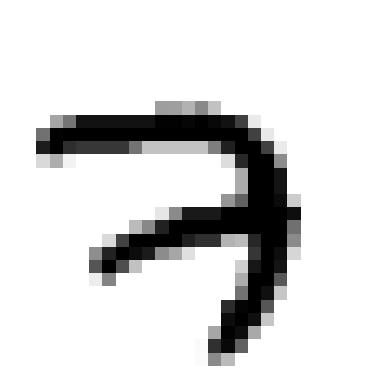

In [24]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a class_names array:

In [25]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [26]:
X_valid.shape, X_test.shape

((5000, 28, 28), (10000, 28, 28))

Let's take a look at a sample of the images in the dataset:

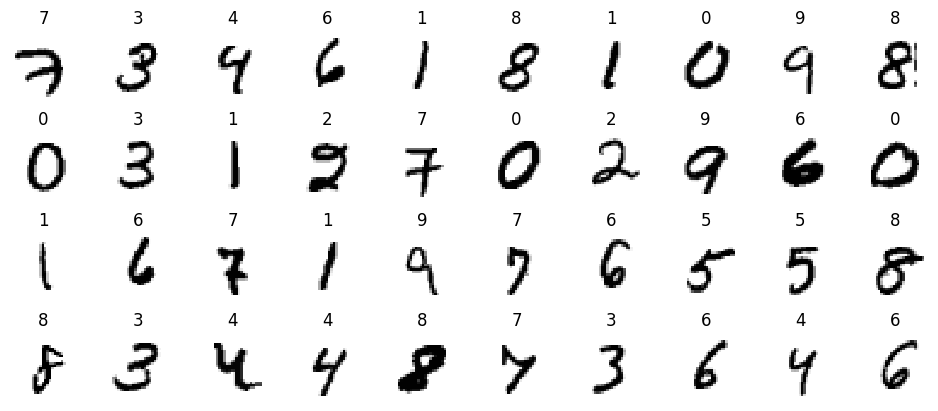

In [27]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

自定義callback，記錄每次迭代的學習率和損失。通過利用此 ExponentialLearningRate callback，可以在訓練期間監控學習率進度和損失值，同時以指數方式調整模型優化器在訓練期間的學習率。

In [28]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    
    #factor參數表示在每個批處理結束時學習率乘以的數。構造函數還初始化兩個清單self.rates和 self.losses ，以存儲訓練期間的學習率和損失。
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    
    #在訓練期間在每個批處理結束時執行的回調方法。它由Keras訓練迴圈調用。在此方法中，當前學習率 （ self.model.optimizer.learning_rate ） 
    #使用 K.get_value() 獲得，並將其附加到 self.rates 清單中。損失值 （ logs["loss"] ） 也附加到 self.losses 清單中。
    # 然後，通過將學習率與 factor 應用指數調整的using K.set_value() 相乘來更新學習率。
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [29]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

We will start with a small learning rate of 1e-3(0.001), and grow it by 0.5% at each iteration:

In [32]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Now let's train the model for just 1 epoch:

In [33]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 5s 3ms/step - loss: nan - accuracy: 0.5764 - val_loss: nan - val_accuracy: 0.0958


We can now plot the loss as a functionof the learning rate:

Text(0, 0.5, 'Loss')

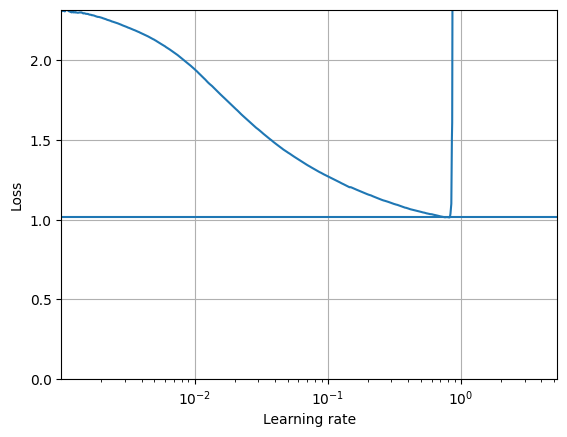

In [34]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

10^-2是0.01，10^-1是0.1，10^0是1

The loss starts shooting back up violently when the learning rate goes over 6e-1(0.6), so let's try using half of that, at 3e-1(0.3):

In [37]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [39]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [48]:
from time import strftime
from pathlib import Path
def get_run_logdir(root_logdir="my_mnist_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")
run_logdir = get_run_logdir()


In [49]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model")
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir, profile_batch=(100,200))

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1704/1719 [============================>.] - ETA: 0s - loss: 1.1517e-05 - accuracy: 1.0000

INFO:tensorflow:Assets written to: my_mnist_model\assets


INFO:tensorflow:Assets written to: my_mnist_model\assets


1719/1719 [==============================] - 6s 3ms/step - loss: 1.1447e-05 - accuracy: 1.0000 - val_loss: 0.1116 - val_accuracy: 0.9858
Epoch 2/100
1711/1719 [============================>.] - ETA: 0s - loss: 1.1109e-05 - accuracy: 1.0000

INFO:tensorflow:Assets written to: my_mnist_model\assets


INFO:tensorflow:Assets written to: my_mnist_model\assets


1719/1719 [==============================] - 5s 3ms/step - loss: 1.1095e-05 - accuracy: 1.0000 - val_loss: 0.1118 - val_accuracy: 0.9858
Epoch 3/100
1697/1719 [============================>.] - ETA: 0s - loss: 1.0803e-05 - accuracy: 1.0000

INFO:tensorflow:Assets written to: my_mnist_model\assets


INFO:tensorflow:Assets written to: my_mnist_model\assets


1719/1719 [==============================] - 5s 3ms/step - loss: 1.0762e-05 - accuracy: 1.0000 - val_loss: 0.1120 - val_accuracy: 0.9858
Epoch 4/100
1717/1719 [============================>.] - ETA: 0s - loss: 1.0456e-05 - accuracy: 1.0000

INFO:tensorflow:Assets written to: my_mnist_model\assets


INFO:tensorflow:Assets written to: my_mnist_model\assets


1719/1719 [==============================] - 5s 3ms/step - loss: 1.0449e-05 - accuracy: 1.0000 - val_loss: 0.1122 - val_accuracy: 0.9858
Epoch 5/100
1698/1719 [============================>.] - ETA: 0s - loss: 1.0180e-05 - accuracy: 1.0000

INFO:tensorflow:Assets written to: my_mnist_model\assets


INFO:tensorflow:Assets written to: my_mnist_model\assets


1719/1719 [==============================] - 6s 3ms/step - loss: 1.0164e-05 - accuracy: 1.0000 - val_loss: 0.1124 - val_accuracy: 0.9858
Epoch 6/100
1711/1719 [============================>.] - ETA: 0s - loss: 9.9235e-06 - accuracy: 1.0000

INFO:tensorflow:Assets written to: my_mnist_model\assets


INFO:tensorflow:Assets written to: my_mnist_model\assets


1719/1719 [==============================] - 6s 3ms/step - loss: 9.8868e-06 - accuracy: 1.0000 - val_loss: 0.1126 - val_accuracy: 0.9858
Epoch 7/100
1710/1719 [============================>.] - ETA: 0s - loss: 9.6567e-06 - accuracy: 1.0000

INFO:tensorflow:Assets written to: my_mnist_model\assets


INFO:tensorflow:Assets written to: my_mnist_model\assets


1719/1719 [==============================] - 5s 3ms/step - loss: 9.6286e-06 - accuracy: 1.0000 - val_loss: 0.1128 - val_accuracy: 0.9858
Epoch 8/100
1717/1719 [============================>.] - ETA: 0s - loss: 9.3899e-06 - accuracy: 1.0000

INFO:tensorflow:Assets written to: my_mnist_model\assets


INFO:tensorflow:Assets written to: my_mnist_model\assets


1719/1719 [==============================] - 6s 3ms/step - loss: 9.3882e-06 - accuracy: 1.0000 - val_loss: 0.1129 - val_accuracy: 0.9858
Epoch 9/100
1719/1719 [==============================] - ETA: 0s - loss: 9.1529e-06 - accuracy: 1.0000

INFO:tensorflow:Assets written to: my_mnist_model\assets


INFO:tensorflow:Assets written to: my_mnist_model\assets


1719/1719 [==============================] - 6s 3ms/step - loss: 9.1529e-06 - accuracy: 1.0000 - val_loss: 0.1131 - val_accuracy: 0.9860
Epoch 10/100
1710/1719 [============================>.] - ETA: 0s - loss: 8.9574e-06 - accuracy: 1.0000

INFO:tensorflow:Assets written to: my_mnist_model\assets


INFO:tensorflow:Assets written to: my_mnist_model\assets


1719/1719 [==============================] - 6s 3ms/step - loss: 8.9339e-06 - accuracy: 1.0000 - val_loss: 0.1133 - val_accuracy: 0.9860
Epoch 11/100
1701/1719 [============================>.] - ETA: 0s - loss: 8.7052e-06 - accuracy: 1.0000

INFO:tensorflow:Assets written to: my_mnist_model\assets


INFO:tensorflow:Assets written to: my_mnist_model\assets


1719/1719 [==============================] - 5s 3ms/step - loss: 8.7244e-06 - accuracy: 1.0000 - val_loss: 0.1135 - val_accuracy: 0.9858
Epoch 12/100
1716/1719 [============================>.] - ETA: 0s - loss: 8.5356e-06 - accuracy: 1.0000

INFO:tensorflow:Assets written to: my_mnist_model\assets


INFO:tensorflow:Assets written to: my_mnist_model\assets


1719/1719 [==============================] - 6s 3ms/step - loss: 8.5265e-06 - accuracy: 1.0000 - val_loss: 0.1136 - val_accuracy: 0.9858
Epoch 13/100
1708/1719 [============================>.] - ETA: 0s - loss: 8.3459e-06 - accuracy: 1.0000

INFO:tensorflow:Assets written to: my_mnist_model\assets


INFO:tensorflow:Assets written to: my_mnist_model\assets


1719/1719 [==============================] - 5s 3ms/step - loss: 8.3374e-06 - accuracy: 1.0000 - val_loss: 0.1138 - val_accuracy: 0.9858
Epoch 14/100
1702/1719 [============================>.] - ETA: 0s - loss: 8.1643e-06 - accuracy: 1.0000

INFO:tensorflow:Assets written to: my_mnist_model\assets


INFO:tensorflow:Assets written to: my_mnist_model\assets


1719/1719 [==============================] - 5s 3ms/step - loss: 8.1570e-06 - accuracy: 1.0000 - val_loss: 0.1139 - val_accuracy: 0.9858
Epoch 15/100
1712/1719 [============================>.] - ETA: 0s - loss: 7.9523e-06 - accuracy: 1.0000

INFO:tensorflow:Assets written to: my_mnist_model\assets


INFO:tensorflow:Assets written to: my_mnist_model\assets


1719/1719 [==============================] - 5s 3ms/step - loss: 7.9847e-06 - accuracy: 1.0000 - val_loss: 0.1141 - val_accuracy: 0.9858
Epoch 16/100
1697/1719 [============================>.] - ETA: 0s - loss: 7.8084e-06 - accuracy: 1.0000

INFO:tensorflow:Assets written to: my_mnist_model\assets


INFO:tensorflow:Assets written to: my_mnist_model\assets


1719/1719 [==============================] - 5s 3ms/step - loss: 7.8201e-06 - accuracy: 1.0000 - val_loss: 0.1143 - val_accuracy: 0.9858
Epoch 17/100
1715/1719 [============================>.] - ETA: 0s - loss: 7.6481e-06 - accuracy: 1.0000

INFO:tensorflow:Assets written to: my_mnist_model\assets


INFO:tensorflow:Assets written to: my_mnist_model\assets


1719/1719 [==============================] - 5s 3ms/step - loss: 7.6658e-06 - accuracy: 1.0000 - val_loss: 0.1144 - val_accuracy: 0.9858
Epoch 18/100
1709/1719 [============================>.] - ETA: 0s - loss: 7.5240e-06 - accuracy: 1.0000

INFO:tensorflow:Assets written to: my_mnist_model\assets


INFO:tensorflow:Assets written to: my_mnist_model\assets


1719/1719 [==============================] - 5s 3ms/step - loss: 7.5143e-06 - accuracy: 1.0000 - val_loss: 0.1145 - val_accuracy: 0.9858
Epoch 19/100
1697/1719 [============================>.] - ETA: 0s - loss: 7.3716e-06 - accuracy: 1.0000

INFO:tensorflow:Assets written to: my_mnist_model\assets


INFO:tensorflow:Assets written to: my_mnist_model\assets


1719/1719 [==============================] - 5s 3ms/step - loss: 7.3717e-06 - accuracy: 1.0000 - val_loss: 0.1147 - val_accuracy: 0.9858
Epoch 20/100
1708/1719 [============================>.] - ETA: 0s - loss: 7.2203e-06 - accuracy: 1.0000

INFO:tensorflow:Assets written to: my_mnist_model\assets


INFO:tensorflow:Assets written to: my_mnist_model\assets


1719/1719 [==============================] - 5s 3ms/step - loss: 7.2341e-06 - accuracy: 1.0000 - val_loss: 0.1148 - val_accuracy: 0.9858
Epoch 21/100
1704/1719 [============================>.] - ETA: 0s - loss: 7.1258e-06 - accuracy: 1.0000

INFO:tensorflow:Assets written to: my_mnist_model\assets


INFO:tensorflow:Assets written to: my_mnist_model\assets


1719/1719 [==============================] - 5s 3ms/step - loss: 7.1012e-06 - accuracy: 1.0000 - val_loss: 0.1149 - val_accuracy: 0.9858


In [51]:
model = tf.keras.models.load_model("my_mnist_model") # rollback to best model
model.evaluate(X_test, y_test, return_dict=True)

313/313 [==============================] - 1s 1ms/step - loss: 0.1017 - accuracy: 0.9849


{'loss': 0.10172810405492783, 'accuracy': 0.9848999977111816}

We got over 98% accuracy. Finally, let's look at the learning curves using TensorBoard:

In [ ]:
%tensorboard --logdir=./my_mnist_logs